In [13]:
from ThematicTextClassify.TextClassifier import *
from ThematicTextClassify.Preprocessing import *

In [14]:
df =pd.read_csv('Categorized_Links.csv')

In [15]:
# add the title and description column together to form a text document
df['Text'] = df['Title']+ df['Description']
df = df.dropna(subset= ['Text'], axis = 0)

# preprocess the newly defined Text column
df['Processed Text'] = df['Text'].map(preprocess_text)
df['processed_string'] =  [' '.join(text) for text in df['Processed Text']]

In [16]:
df['Class'] = ""
df['Class'] = df.apply(lambda df: 'Health Outcome' if (df['Category'] == 'Health Outcome') else df['Class'], axis =1)
df['Class'] = df.apply(lambda df: 'Other' if (df['Category'] != 'Health Outcome') else df['Class'], axis =1)
df = df.reset_index(drop=True)
df = df.sort_values('Class')
df = df.reset_index(drop=True)
df = df.drop_duplicates(['Link'],keep= 'first')
df = df.reset_index(drop=True)
len(df)

301

In [17]:
text_train, text_test, class_train, class_test = train_test_split(df,
                                                    df['Class'],
                                                    test_size=0.20, 
                                                    random_state=501)

In [18]:
class_test.value_counts()

Other             48
Health Outcome    13
Name: Class, dtype: int64

In [19]:
class_train.value_counts()

Other             200
Health Outcome     40
Name: Class, dtype: int64

# Most Frequent words for Health Outcome

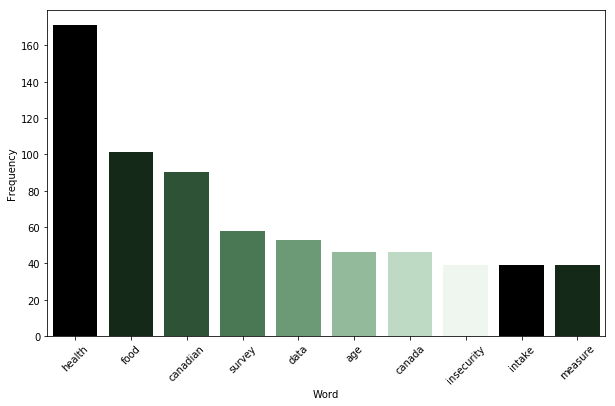

In [8]:
cv = CountVectorizer()
consumption = df[df['Class'] == 'Health Outcome']['processed_string']
bow_consumption = cv.fit_transform(consumption)
freq_consumption = dict(zip(cv.get_feature_names(), np.asarray(bow_consumption.sum(axis=0)).ravel()))
count_consumption = pd.DataFrame(collections.Counter(freq_consumption).most_common(10), columns = ['Word', 'Frequency'])
fig, ax = plt.subplots(figsize=(10, 6))
colour = sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True)
g = sns.barplot(x="Word", y="Frequency", data=count_consumption, palette=colour, ax=ax)
loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45)
plt.show();

# General Check on Accuracy using CountVectorizer

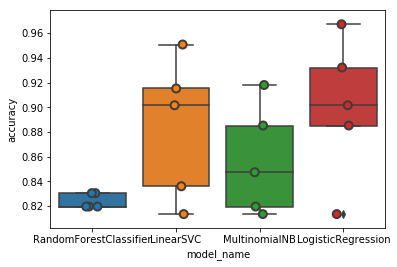

model_name
LinearSVC                 0.883468
LogisticRegression        0.899972
MultinomialNB             0.856794
RandomForestClassifier    0.824007
Name: accuracy, dtype: float64

In [10]:
countvect = CountVectorizer()
features = countvect.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 3000),MultinomialNB(),LogisticRegression(random_state=0)]

cv_df = pd.DataFrame(index=range(5 * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# General Check on Accuracy using tfidf

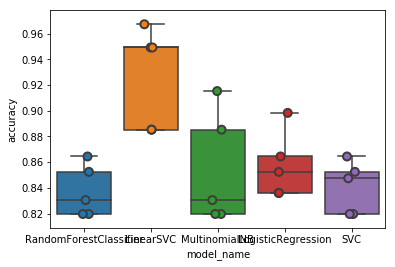

model_name
LinearSVC                 0.927202
LogisticRegression        0.857460
MultinomialNB             0.854071
RandomForestClassifier    0.837344
SVC                       0.840734
Name: accuracy, dtype: float64

In [11]:
tfidf = TfidfVectorizer() 
features = tfidf.fit_transform(df['processed_string']).toarray()
labels = df['Class']

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),LinearSVC(max_iter = 2000),MultinomialNB(),LogisticRegression(random_state=0), SVC(kernel ='linear', degree = 1, C = 0.25)]
cv_df = pd.DataFrame(index=range(5 * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=5)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
import warnings
warnings.filterwarnings('ignore')
plt.show()
cv_df.groupby('model_name').accuracy.mean()

# Multinomial Naive Bayes (CountVectorizer)

In [12]:
mnb = MultinomialNB()
logreg = LogisticRegression()
countvect = CountVectorizer()
mnb_countvect = grid_vect(mnb, param_mnb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed:   39.9s finished


done in 40.473s


Best CV score: 0.933
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 3)
Cross Validated Test score with best_estimator_: 0.967


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.85      0.92        13
         Other       0.96      1.00      0.98        48

      accuracy                           0.97        61
     macro avg       0.98      0.92      0.95        61
  weighted avg       0.97      0.97      0.97        61

Accuracy Score:  0.9672131147540983


# Multinomial Naive Bayes (TFIDF)

In [11]:
mnb_countvect = grid_vect(mnb, param_mnb, text_train,class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed:  3.0min finished


done in 178.027s


Best CV score: 0.942
Best parameters set:
	clf__alpha: 0.25
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
	features__pipe__vect__norm: 'l2'
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.62      0.76        13
         Other       0.91      1.00      0.95        48

      accuracy                           0.92        61
     macro avg       0.95      0.81      0.86        61
  weighted avg       0.93      0.92      0.91        61

Accuracy Score:  0.9180327868852459


# Logistic Regression (CountVectorizer)

In [13]:
logreg_countvect = grid_vect(logreg, param_logreg, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)



Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  1.6min finished


done in 97.553s


Best CV score: 0.938
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l2'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.934


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.69      0.82        13
         Other       0.92      1.00      0.96        48

      accuracy                           0.93        61
     macro avg       0.96      0.85      0.89        61
  weighted avg       0.94      0.93      0.93        61

Accuracy Score:  0.9344262295081968


# Logisitc Regression (TFIDF)


In [12]:
logreg_tfidf = grid_vect(logreg, param_logreg, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 810 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed:  5.4min finished
/Users/chi/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


done in 326.377s


Best CV score: 0.942
Best parameters set:
	clf__C: 0.25
	clf__penalty: 'l1'
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
	features__pipe__vect__norm: None
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.62      0.76        13
         Other       0.91      1.00      0.95        48

      accuracy                           0.92        61
     macro avg       0.95      0.81      0.86        61
  weighted avg       0.93      0.92      0.91        61

Accuracy Score:  0.9180327868852459


# Linear SVC (CountVectorizer)

In [15]:
linsvc = LinearSVC() 
lscv_countvect = grid_vect(linsvc, param_linearsvc, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect= countvect)





Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.4min finished


done in 85.032s


Best CV score: 0.933
Best parameters set:
	clf__C: 0.05
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.934


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.69      0.82        13
         Other       0.92      1.00      0.96        48

      accuracy                           0.93        61
     macro avg       0.96      0.85      0.89        61
  weighted avg       0.94      0.93      0.93        61

Accuracy Score:  0.9344262295081968


# Linear SVC (TFIDF)

In [16]:
linsvc = LinearSVC() 
lscv_tfidf = grid_vect(linsvc, param_linearsvc, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)




Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   54.2s


done in 76.565s


Best CV score: 0.925
Best parameters set:
	clf__C: 0.25
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 1)
Cross Validated Test score with best_estimator_: 0.902


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.54      0.70        13
         Other       0.89      1.00      0.94        48

      accuracy                           0.90        61
     macro avg       0.94      0.77      0.82        61
  weighted avg       0.91      0.90      0.89        61

Accuracy Score:  0.9016393442622951


[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  1.3min finished


# Random Forest Classifier (CountVectorizer)

In [23]:
RandF = RandomForestClassifier()
Randomforest_countvect = grid_vect(RandF, param_RandF, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)




Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed: 19.3min finished


done in 1159.296s


Best CV score: 0.879
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 300
	clf__random_state: 2
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.15      0.27        13
         Other       0.81      1.00      0.90        48

      accuracy                           0.82        61
     macro avg       0.91      0.58      0.58        61
  weighted avg       0.85      0.82      0.76        61

Accuracy Score:  0.819672131147541


# Random Forest Classifier (TFIDF)

In [13]:
Randomforest_tfidf = grid_vect(RandF, param_RandF, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 35.4min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

done in 3297.669s


Best CV score: 0.879
Best parameters set:
	clf__max_depth: 4
	clf__n_estimators: 200
	clf__random_state: 0
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
	features__pipe__vect__norm: 'l2'
Cross Validated Test score with best_estimator_: 0.820


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.15      0.27        13
         Other       0.81      1.00      0.90        48

      accuracy                           0.82        61
     macro avg       0.91      0.58      0.58        61
  weighted avg       0.85      0.82      0.76        61

Accuracy Score:  0.819672131147541


# XGboost (CountVectorizer)

In [8]:
countvect = CountVectorizer()
xgb = XGBClassifier(random_state=1995,colsample_bytree=0.3, subsample=0.3)
XGboost_tfidf = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_countvect, vect=countvect)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 39.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 61.6min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 80.4min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 96.6min finished


done in 5797.421s


Best CV score: 0.921
Best parameters set:
	clf__max_depth: 6
	clf__seed: 1
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 3
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.869


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       0.86      0.46      0.60        13
         Other       0.87      0.98      0.92        48

      accuracy                           0.87        61
     macro avg       0.86      0.72      0.76        61
  weighted avg       0.87      0.87      0.85        61

Accuracy Score:  0.8688524590163934


# XGboost (TFIDF)

In [9]:
tfidf = TfidfVectorizer() 
XGboost_countvect = grid_vect(xgb, param_xgb, text_train, class_train, text_test, class_test, parameters_text=param_vect_tfidf, vect=tfidf)


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 35.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 46.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 57.3min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 69.3min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 83.3min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 96.8min
[Parallel(n_jobs=-1)]: Done 8100 out of 8100 | elapsed: 106.6min finished


done in 6398.640s


Best CV score: 0.933
Best parameters set:
	clf__max_depth: 4
	clf__seed: 1
	clf__subsample: 0.7
	features__pipe__vect__max_df: 0.75
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Cross Validated Test score with best_estimator_: 0.918


Classification Report Test Data


                precision    recall  f1-score   support

Health Outcome       1.00      0.62      0.76        13
         Other       0.91      1.00      0.95        48

      accuracy                           0.92        61
     macro avg       0.95      0.81      0.86        61
  weighted avg       0.93      0.92      0.91        61

Accuracy Score:  0.9180327868852459
